## Transfer Learning VGG 16 and VGG 19 using Keras

Please download the dataset from the below url

In [1]:
import tensorflow as tf 

if tf.test.gpu_device_name(): 
    

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [2]:
!nvidia-smi

Sun Jan 03 11:06:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.51       Driver Version: 457.51       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0    13W /  N/A |    293MiB /  4096MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob


In [6]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'Datasets/train'
valid_path = 'Datasets/test'


In [7]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)




In [8]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [10]:
  # useful for getting number of output classes
folders = glob('Datasets/train/*')

In [11]:
folders

['Datasets/train\\cats', 'Datasets/train\\dogs']

In [12]:
# our layers - you can add more if you want
x = Flatten()(vgg16.output)

In [13]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [14]:

# view the structure of the model
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [15]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [16]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 8000 images belonging to 2 classes.


In [18]:
test_set = test_datagen.flow_from_directory('Datasets/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 2000 images belonging to 2 classes.


In [21]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/2
250/250 [==============================] - 121s 484ms/step - loss: 0.1648 - accuracy: 0.9327 - val_loss: 0.1910 - val_accuracy: 0.9310
Epoch 2/2
250/250 [==============================] - 118s 472ms/step - loss: 0.1780 - accuracy: 0.9311 - val_loss: 0.2268 - val_accuracy: 0.9170


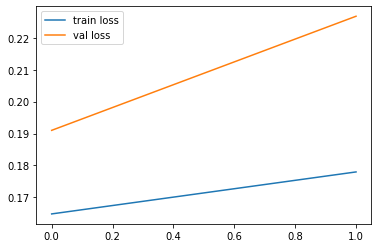

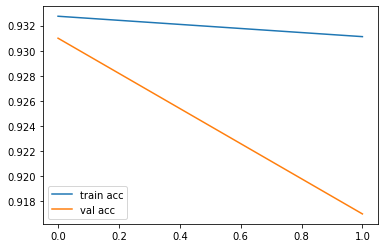

<Figure size 432x288 with 0 Axes>

In [22]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [23]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_vgg16.h5')

In [24]:

y_pred = model.predict(test_set)


In [25]:
y_pred

array([[1.3180076e-07, 9.9999988e-01],
       [9.8871607e-01, 1.1283976e-02],
       [9.9970645e-01, 2.9357400e-04],
       ...,
       [2.9481781e-09, 1.0000000e+00],
       [1.0793915e-01, 8.9206088e-01],
       [7.3950451e-07, 9.9999928e-01]], dtype=float32)

In [26]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [27]:
y_pred

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

In [28]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
model=load_model('model_resnet50.h5')

In [29]:
img_data

NameError: name 'img_data' is not defined

In [34]:
img=image.load_img('Datasets/test/cats/cat.4001.jpg',target_size=(224,224))



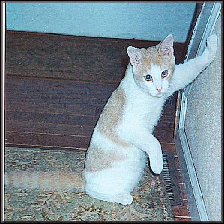

In [35]:
img

In [36]:
x=image.img_to_array(img)
x

array([[[  3.,   0.,   0.],
        [ 18.,   0.,   7.],
        [ 14.,   0.,  14.],
        ...,
        [  6.,   0.,   2.],
        [ 24.,  18.,  20.],
        [  1.,   1.,   3.]],

       [[ 15.,  11.,   8.],
        [119.,  91., 106.],
        [123., 105., 121.],
        ...,
        [103.,  98., 104.],
        [ 90.,  85.,  89.],
        [  1.,   1.,   3.]],

       [[  4.,   0.,   0.],
        [129., 101., 113.],
        [134., 118., 129.],
        ...,
        [ 92.,  96., 105.],
        [ 68.,  67.,  73.],
        [  1.,   1.,   3.]],

       ...,

       [[ 10.,   8.,  13.],
        [110.,  97., 106.],
        [ 94.,  78.,  88.],
        ...,
        [ 64.,  68.,  69.],
        [ 66.,  68.,  67.],
        [  1.,   1.,   3.]],

       [[  6.,  12.,  12.],
        [ 81.,  75.,  79.],
        [ 66.,  55.,  61.],
        ...,
        [ 48.,  50.,  49.],
        [ 57.,  62.,  58.],
        [  1.,   1.,   3.]],

       [[  0.,  11.,   7.],
        [  5.,   5.,   5.],
        [ 12.,  

In [37]:
x.shape

(224, 224, 3)

In [38]:
x=x/255

In [39]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [40]:
model.predict(img_data)

array([[9.9999034e-01, 9.6394324e-06]], dtype=float32)

In [41]:
a=np.argmax(model.predict(img_data), axis=1)

In [42]:
a==1

array([False])